# Topic Model Diagnostics

## Load Word Counts by Topic / Parse into Tidy Structure

In [ ]:
import pandas as pd
import re

def tidy_word_count(data, row):
    df = pd.DataFrame({'term': [], 'topic_count':[]})
    try:
        topic_count = data[row][2:len(data[row])]    
        df = pd.DataFrame({'topic_count': topic_count})  
        df['term'] = data[row][1]    
    except:
        pass
    return df

data = []
with open('/Users/dankoban/Documents/EM6575/mallet_command_line/ct.wordtopiccounts','r') as infile:
    for line in infile:        
        line = line.split(' ')        
        data.append(line)      

counter = 0
tidy_dfs = []
for i in range(0, len(data)):
    tidy_dfs.append(tidy_word_count(data = data, row = i))
    counter += 1
    if counter %10000 == 0:
        print(str(counter) + ' out of ' + str(len(data)))
        
df = pd.concat(tidy_dfs)

df['topic_count'] = df['topic_count'].apply(lambda x: re.sub(r'\n', '', x)) 
df['topic'] = df['topic_count'].apply(lambda x: x.split(":")[0])
df['count'] = df['topic_count'].apply(lambda x: x.split(":")[1])
df = df[['term', 'topic', 'count']]            
df.reset_index(inplace = True, drop = True)
#df.to_csv('/Users/dankoban/Documents/EM6575/mallet_command_line/ct_tidy_topics.csv', index=False)        

## Load Topics by Documents / Parse into Tidy Structure

In [ ]:
import pandas as pd
def tidy_doc_to_topic(data, max_topics_per_doc):
    df = pd.DataFrame({'topics': [], 'proportion':[],
                       'doc_id': [], 'file':[]})
    try:
        topics = [data[2]]
        proportions = [data[3]]
        for i in range(0, max_topics_per_doc):
            try: 
                topics.append(data[2*(i+1)+2])
                proportions.append(data[2*(i+1)+3])
            except:
                pass

        df = pd.DataFrame({'topics': topics,
                           'proportion': proportions})
        df['doc_id'] = data[0]
        df['file'] = data[1]
        return df
    except: 
        pass

data = []
with open('/Users/dankoban/Documents/EM6575/mallet_command_line/ct.doctopics_sparse','r') as infile:
    for line in infile:        
        line = line.rstrip().split('\t')
        data.append(line)
len(data)

counter = 0
tidy_dfs = []
for i in range(1, len(data)):    
    tidy_dfs.append(tidy_doc_to_topic(data = data[i], max_topics_per_doc = 10))
    counter += 1
    if counter %25000 == 0:
        print(str(counter) + ' out of ' + str(len(data)))

df = pd.concat(tidy_dfs)

df.reset_index(inplace = True, drop = True)
#df.to_csv('/Users/dankoban/Documents/EM6575/mallet_command_line/ct_tidy_docs2topics.csv', index=False)  

## Load data from step 1 and 2

Load the parsed data to save processing time.

In [1]:
import seaborn as sns
import pandas as pd
import math

TopicTermFreq = pd.read_csv('/Users/dankoban/Documents/EM6575/mallet_command_line/tidy_topics.csv')
TopicTermFreq.head()

,term,topic,count
0,nika,0,5
1,nika,19,2
2,vetsko,19,2
3,excerpts,14,18
4,excerpts,19,7


In [2]:
docs2topic = pd.read_csv('/Users/dankoban/Documents/EM6575/mallet_command_line/tidy_docs2topics.csv')
docs2topic.head()

,topics,proportion,doc_id,file
0,19,0.845955,0,0
1,16,0.517581,1,1
2,10,0.466619,1,1
3,1,0.664968,3,3
4,4,0.607193,4,4


## Tokens per Topic

These descriptions are designed to make sense without mathematical definitions, but we include them for specificity. We'll use the symbols $w$ for a word, $k$ for a topic, and $d$ for a document. Several metrics count tokens. For these we define variables $N_{d,w,k}$ as the number of times word $w$ occurs in document $d$ assigned to topic $k$, $N_{d,k}$ as $\sum_wN_{d,w,k}$. Other metrics involve document frequencies. $D(w)$ is the number of documents that contain at least one token of type $w$, and $D(w_1,w_2)$ is the number of documents that contain at least one $w_1$ and one $w_2$. Finally, we define $W_k$ to be the $N$ most probable words in topic $k$. $𝟙(p)$ is equal to 1 if predicate $p$ is true, and 0 otherwise.

**Tokens.** This metric measures the number of word tokens currently assigned to the topic $N_k=\sum_dN_{d,k}$. Comparing this number to the sum of the token counts for all topics will give you the proportion of the corpus assigned to the topic. If you are using optimized hyperparameters this number will vary considerably across topics; otherwise it will be roughly the same for all topics. We usually find topics most interesting if they are not on the extremes of this range. Small numbers (relative to other topics) are often a sign that a topic may not be reliable: we don't have enough observations to get a good sense of the topic's word distribution. Large numbers may also be bad: extremely frequent topics are often "not-quite-stopwords". For example, in the sample model the largest topic is "time number term part system form".

In [3]:
num_topics = 20
tokens_by_topic = []
for i in range(0, num_topics):
    token_count = sum(TopicTermFreq[TopicTermFreq['topic'] == i]['count'])
    tokens_by_topic.append([i, token_count])
tokens_by_topic = pd.DataFrame(tokens_by_topic,
                               columns = ['topic', 'token_count'])
tokens_by_topic.head()    

,topic,token_count
0,0,395603
1,1,1286265
2,2,364760
3,3,414907
4,4,551878


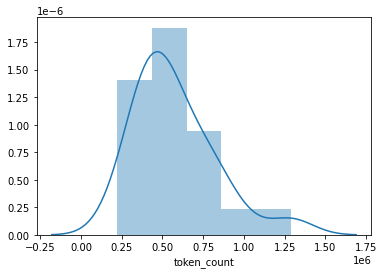

In [4]:
sns.distplot(tokens_by_topic["token_count"])

In [5]:
def top_n_terms(k, n = 10):
    result = (TopicTermFreq[TopicTermFreq['topic'] == k].
                  sort_values('count', ascending=False).head(n))
    return result

pd.set_option('display.max_colwidth', None)
topic_top_n = []
for i in range(0, num_topics):
    concat_terms = ', '.join(top_n_terms(i, n = 20)['term'].tolist())
    topic_top_n.append([i, concat_terms])

topic_tbl = pd.DataFrame(topic_top_n, columns = ['topic', 'top_n_terms'])
topic_tbl

,topic,top_n_terms
0,0,"coronavirus, covid, live, news, island, questions, updates, april, update, join, code, latest, tests, zip, watch, richest, staff, health, america, information"
1,1,"covid, health, coronavirus, information, public, spread, stay, contact, hands, home, safety, community, continue, disease, symptoms, safe, staff, time, cdc, virus"
2,2,"coronavirus, sports, league, season, pandemic, due, football, minister, players, premier, outbreak, amid, positive, prime, world, games, nba, australia, zealand, fans"
3,3,"coronavirus, state, gov, governor, order, spread, emergency, public, covid, update, california, home, outbreak, michigan, continues, executive, pandemic, announced, health, days"
4,4,"trump, coronavirus, president, house, donald, white, pandemic, health, funding, tested, response, u.s, world, bill, national, emergency, test, testing, force, states"
5,5,"covid, city, coronavirus, quarantine, disease, government, manila, police, department, ang, health, public, community, philippines, april, local, metro, national, march, travel"
6,6,"coronavirus, covid, photos, home, time, stay, timeline, support, safe, people, pandemic, kids, post, free, share, make, social, children, online, community"
7,7,"covid, coronavirus, care, workers, health, hospital, medical, patients, testing, support, pandemic, masks, healthcare, community, hospitals, staff, people, emergency, test, working"
8,8,"coronavirus, pandemic, covid, businesses, business, economic, crisis, support, workers, small, million, economy, relief, cial, government, federal, fund, impact, billion, employees"
9,9,"school, schools, students, coronavirus, march, closed, online, county, district, education, monday, covid, public, classes, learning, families, university, college, free, due"


## 2. Document Entropy

We usually think of the probability of a topic given a document. For this metric we calculate the probability of documents given a topic. <br> <br>
<center>
$P(d|k)=\frac{N_{d,k}}{\sum_{d′}N_{d′,k}}$
</center>
<br> 
We count the frequency of a topic over all documents, and normalize to get a distribution, then calculate the entropy of that distribution $H(P(d|k))$. A topic with low entropy (i.e., high predictability) will be concentrated in a few documents, while a topic with higher entropy will be spread evenly over many documents. In the example topic model, the topics "list links history external information site" and "game team league player players football games" have roughly the same number of tokens, but the "list" topic has much higher entropy. It occurs to a small degree in many documents, while the "game" topic occurs a lot in a smaller number of documents. Low entropy isn't necessarily good: it can indicate unusual documents (did you accidentally import the Mac .DS_Store file?) or the presence of documents in other languages.

In [6]:
topics = docs2topic['topics'].unique()
document_total_n = len(docs2topic['doc_id'].unique())

#frequency of a topic over all documents
topic_k_count = len(docs2topic[docs2topic['topics'] == topics[0]])
freq_topic_k = topic_k_count/document_total_n

docs_per_topic = (docs2topic['topics'].
                        value_counts().
                        reset_index().
                        rename(columns = {'index': 'topics',
                                          'topics': 'doc_count'}))

docs_per_topic['freq'] = docs_per_topic['doc_count'].apply(lambda x: x/document_total_n)
docs_per_topic.head()

,topics,doc_count,freq
0,10,28105,0.107455
1,6,27934,0.106801
2,1,25124,0.096057
3,14,24859,0.095044
4,7,20197,0.077220


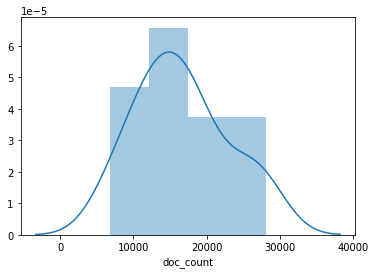

In [7]:
sns.distplot(docs_per_topic["doc_count"])

In [8]:
topics_per_doc = (docs2topic['doc_id'].
                        value_counts().
                        reset_index().
                        rename(columns = {'index': 'doc_id',
                                          'doc_id': 'topic_count'}))

topic_counts = (topics_per_doc['topic_count'].
                        value_counts().
                        reset_index().
                        rename(columns = {'index': 'topic_count',
                                          'topic_count': 'count'}))

topic_counts['freq'] = topic_counts['count'].apply(lambda x: x/sum(topic_counts['count']))
topic_counts

,topic_count,count,freq
0,1,191718,0.733001
1,2,69376,0.265247
2,3,458,0.001751


In [ ]:
def doc_entropy(doc_id, topic_freq):
    topics_in_doc = docs2topic[docs2topic['doc_id']==doc_id]['topics'].tolist()
    probabilities = topic_freq['freq'][topic_freq['topics'].isin([topic for topic in topics_in_doc])]
    entropy = sum([-prob*math.log2(prob) for prob in probabilities])
    return entropy 

#####################################
# Takes a very long time to calculate
#####################################

docs2topic['doc_entropy'] = docs2topic['doc_id'].apply(
    lambda x: doc_entropy(x, topic_freq = docs_per_topic))

document_entropy = docs2topic

In [ ]:
#document_entropy = pd.read_csv('/Users/dankoban/Documents/EM6575/mallet_command_line/document_entropy.csv') 

## 3. Word Length 

The average length, in characters, of the displayed top words. <br><br>
<center>
$\frac{1}{|W|}\sum_{w∈W}len(w)$ 
</center>
<br>
Words are not weighted by probablity or rank position. This is a useful proxy for topic specificity. Longer words often carry more specific meaning, so if the topic brings together lots of short words, it's probably not a very specific topic. This can also be a good way to pick up the "hey, looks like we've got some Spanish!" topic because we often pick up the short words that would be stopwords if we were modeling a corpus in that language. The example topic "de french la france spanish spain italian paris el le" has a number of this type of short words, but they seem to be due to Wikipedia articles talking about French, Spanish, and Italian things rather than actual text in those languages.

In [9]:
topics = TopicTermFreq['topic'].unique().tolist()

topic_ids = []
avg_word_lengths = []
for i in range(0, num_topics):
    top_n = top_n_terms(k = i, n = 20)
    avg_len = top_n['term'].apply(len).mean()
    avg_word_lengths.append(avg_len)
    topic_ids.append(i)

AvgWordLenByTopic = pd.DataFrame({'topic': topic_ids,
                                  'avg_word_length': avg_word_lengths})

AvgWordLenByTopic = AvgWordLenByTopic.sort_values('avg_word_length', ascending = False)
AvgWordLenByTopic.head()

,topic,avg_word_length
7,7,7.10
8,8,7.10
3,3,6.95
5,5,6.90
16,16,6.80


## 4. Coherence

This metric measures whether the words in a topic tend to co-occur together. We add up a score for each distinct pair of top ranked words. The score is the log of the probability that a document containing at least one instance of the higher-ranked word also contains at least one instance of the lower-ranked word. <br><br>
<center>
$\sum_i\sum_jlog\frac{D(w_j,w_i)+β}{D(w_i)}$
</center><br>
To avoid log zero errors we add the "beta" topic-word smoothing parameter specified when you calculate diagnostics. Since these scores are log probabilities they are negative. Large negative values indicate words that don't co-occur often; values closer to zero indicate that words tend to co-occur more often. The least coherent topic in the sample file is "polish poland danish denmark sweden swedish na norway norwegian sk red iceland bj baltic copenhagen cave greenland krak gda faroese". This topic seems to be about Northern and Eastern European countries, but the short abbreviations "na" and "sk" and the words "red" and "cave" don't really fit.

$D(w_j,w_i)$ = number of documents containing $w_i$ and $w_j$

$D(w_i)$ = number of topics containing $w_i$

$W$ = set of words describing the topic

**I think I need the document term matrix**

In [ ]:
top_terms_doc_freq = []
for i in range(0, num_topics):
    top_terms_doc_freq.append(top_n_terms(k = i, n = 20))

top_terms_doc_freq = pd.concat(top_terms_doc_freq)
top_terms_doc_freq.reset_index(drop = True, inplace = True)
top_terms_doc_freq.head()

In [ ]:
beta = 1
top_terms = top_terms_doc_freq['term'].value_counts()

# remove top terms that only appear in one topic
top_terms = (top_terms[top_terms >= 2].
             reset_index().
             rename(columns = {'index': 'term',
                               'term': 'count'}))

from itertools import combinations
pairs = list(combinations(top_terms['term'].tolist(), 2))
print("number top terms: " + str(len(top_terms)))
print(str(len(top_terms)) + " choose 2: " + str(len(pairs)))
pairs[0:5]

In [ ]:
top_terms_topic_k = top_n_terms(k = i, n = 10)['term'].tolist()

co_occur_list = []
for pair in pairs:        
    D_wji = 0
    for i in range(0, num_topics):
        topic_terms = top_terms_doc_freq[top_terms_doc_freq['topic']==i]['term'].to_list()        
        if (pair[0] in topic_terms) & (pair[1] in topic_terms):
            D_wji += 1
    co_occur_list.append([pair[0], pair[1], D_wji])
            
co_occur_df = pd.DataFrame(co_occur_list, columns=['w_j', 'w_i', 'count_topic_containing_both'])           
co_occur_df.head() 

## 5. Uniform Dist

We want topics to be specific. This metric measures the distance from a topic's distribution over words to a uniform distribution. We calculate distance using Kullback-Leibler divergence.<br><br>
<center>
$\sum_wP(w|k)log\frac{P(w|k)}{\frac{1}{|v|}}$
</center><br>
Larger values indicate more specificity.

In [10]:
def calc_KL_diverg_terms(TopicTermFreq, k, n):
    term_count_corpus = len(TopicTermFreq['term'].unique())  
    token_count_topic_k = sum(TopicTermFreq[(TopicTermFreq['topic'] == k)]['count'])
    topic_k_terms = top_n_terms(k = k, n = n)['term'].tolist()
    KL_divergence_terms = []    
    for term in topic_k_terms:    
        term_count = TopicTermFreq[(TopicTermFreq['topic'] == k) & 
                                   (TopicTermFreq['term'] == term)]['count'].tolist()[0]
        P_w_k = term_count/token_count_topic_k
        KL_diverg_term = P_w_k*math.log(P_w_k/(1/term_count_corpus))
        KL_divergence_terms.append([term, KL_diverg_term])
    KL_divergence_terms = pd.DataFrame(KL_divergence_terms, columns = ['Term', 'uniform_dist'])
    return KL_divergence_terms

KL_divergence_terms = calc_KL_diverg_terms(TopicTermFreq, k = 0, n = 10)
KL_divergence_terms.head()

,Term,uniform_dist
0,coronavirus,0.415041
1,covid,0.230197
2,live,0.202341
3,news,0.102971
4,island,0.085894


In [11]:
def calc_KL_diverg_unif(TopicTermFreq, k):
    # calc distribution of topic k
    token_counts_topic_k = TopicTermFreq[(TopicTermFreq['topic'] == k)]['count'].tolist()
    token_count_topic_k = sum(token_counts_topic_k)      
    P_w_k = [count/token_count_topic_k for count in token_counts_topic_k]
    
    # determine number of words in the corpus be used for uniform dist (1/term_count_corpus)
    term_count_corpus = len(TopicTermFreq['term'].unique())        
    KL_diverg_topic = sum([p*math.log(p/(1/term_count_corpus)) for p in P_w_k])
    return KL_diverg_topic

unif_dist = []
for k in range(0, 50):
    unif_dist.append([k, calc_KL_diverg_unif(TopicTermFreq, k = k)])
unif_dist = pd.DataFrame(unif_dist, columns = ['topic', 'uniform_dist'])    
unif_dist.head()

,topic,uniform_dist
0,0,5.192769
1,1,5.518836
2,2,5.114419
3,3,6.017603
4,4,6.112407


## 6. Corpus Dist

This metric measures how far a topic is from the overall distribution of words in the corpus — essentially what you would get if you "trained" a model with one topic. We calculate distance using Kullback-Leibler divergence. A greater distance means the topic is more distinct; a smaller distanace means that the topic is more similar to the corpus distribution. Not surprisingly, it correlates with number of tokens since a topic that makes up a large proportion of the tokens in the corpus is likely to be more similar to the overall corpus distribution. The closest topic to the corpus distribution is "time number term part system form". 

In [12]:
def calc_KL_diverg_corpus(TopicTermFreq, k):
    num_tokens_in_corpus = TopicTermFreq['count'].sum()
    num_tokens_in_topic = TopicTermFreq['count'][TopicTermFreq['topic']==k].sum()
    term_count_corpus_df = TopicTermFreq.groupby('term')['count'].sum().reset_index()
    term_count_corpus_df.columns = ['term', 'corpus_count']
    term_count_topic_k_df = TopicTermFreq[TopicTermFreq['topic'] == k].groupby('term')['count'].sum().reset_index()
    dist_df = term_count_topic_k_df.merge(term_count_corpus_df, how = 'left', on = 'term')
    dist_df['corpus_dist'] = dist_df['corpus_count'].apply(lambda x: x/num_tokens_in_corpus)
    dist_df['topic_dist'] = dist_df['count'].apply(lambda x: x/num_tokens_in_topic)
    KL_diverg = []
    for i in range(0, len(dist_df)):
        KL_diverg.append(dist_df['topic_dist'][i]*math.log(dist_df['topic_dist'][i]/dist_df['corpus_dist'][i]))
    KL_diverg = sum(KL_diverg)   
    return KL_diverg

corpus_dist = []
for k in range(0, num_topics):
    corpus_dist.append([k, calc_KL_diverg_corpus(TopicTermFreq, k = k)])
corpus_dist = pd.DataFrame(corpus_dist, columns = ['topic', 'corpus_dist']) 
corpus_dist.head()

,topic,corpus_dist
0,0,1.640775
1,1,0.917845
2,2,1.702491
3,3,1.566979
4,4,1.504563


## 7. Effective Number of Words

This metric is equivalent to the effective number of parties metric in Political Science. For each word we calculate the inverse of the squared probability of the word in the topic, and then add those numbers up. Larger numbers indicate more specificity. It is similar to distance from the uniform distribution, but produces a value that may be more interpretable.

In [13]:
def calc_effective_num_words(TopicTermFreq, k):
    num_tokens_in_topic = TopicTermFreq['count'][TopicTermFreq['topic']==k].sum()
    topic_dist = TopicTermFreq[['term', 'count']][TopicTermFreq['topic'] == k]
    topic_dist['freq'] = topic_dist['count'].apply(lambda x: x/num_tokens_in_topic) 
    topic_dist['sq_prob'] =  topic_dist['freq'].apply(lambda x: (x*x))
    effective_num_words = 1/sum(topic_dist['sq_prob'])
    return effective_num_words

effective_words = []
for k in range(0, num_topics):
    effective_words.append([k, calc_effective_num_words(TopicTermFreq, k = k)])
effective_words = pd.DataFrame(effective_words, columns = ['topic', 'eff_num_words']) 
effective_words.head()

,topic,eff_num_words
0,0,199.982795
1,1,306.196239
2,2,241.778384
3,3,141.760599
4,4,99.848303


In [ ]:
#eval_summary.to_csv('/Users/dankoban/Documents/EM6575/mallet_command_line/ct_topic_diagnostics_koban.csv', index=False) 

## 8. Token/Document Discrepancy

This metric looks for "bursty" words within topics. We compare two distributions over words using Jensen-Shannon distance. The first distribution $P(w|k)∝N_{k,w}$ is the usual topic-word distribution proportional to the number of tokens of type w that are assigned to the topic. The second distribution $Q(w|k)∝\sum_d𝟙(N_{d,w,k}>0)$ is proportional to the number of documents that contain at least one token of type w that is assigned to the topic. A words that occurs many times in only a few documents may appear prominently in the sorted list of words, but may not be a good representative word for the topic. This metric compares the number of times a word occurs in a topic (measured in tokens) and the number of documents the word occurs in as that topic (instances of the word assigned to other topics are not counted). The highest ranked topic in this metric is the "polish poland danish denmark sweden swedish na norway norwegian sk red" topic, suggesting that those ill-fitting words may be isolated in a few documents. Although this metric has the same goal as coherence, the two don't appear to correlate well: bursty words aren't necessarily unrelated to the topic, they're just unusually frequent in certain contexts.

## 9. Rank 1 Documents

Some topics are specific, while others aren't really "topics" but language that comes up because we are writing in a certain context. Academic writing will talk about "paper abstract data", and a Wikipedia article will talk about "list links history". The difference is often measurable in terms of burstiness. A content-ful topic will occur in relatively few documents, but when it does, it will produce a lot of tokens. A "background" topic will occur in many documents and have a high overall token count, but never produce many tokens in any single document. This metric counts the frequency at which a given topic is the single most frequent topic in a document. Specific topics like "music album band song" or "cell cells disease dna blood treatment" are the "rank 1" topic in many documents. High token-count topics often have few rank-1 documents. This metric is often useful as a way to identify corpus-specific stopwords. But rarer topics can also have few rank-1 documents: "day year calendar days years month" is a representative example — topics for days of the week and units of measurement often appear in documents as a distinct discourse, but they are rarely the focus of a document.


## 10. Allocation Count

This metric has a similar motivation to the rank-1-docs metric. For each document we can calculate the percentage of that document assigned to a given topic. We can then observe how often that percentage is above a certain threshold, by default 30%

## 11. Allocation Ratio

This metric reports the ratio of allocation counts at two different thresholds, by default 50% and 2%.

## 12. Exclusivity

This metric measures the extent to which the top words for this topic are do not appear as top words in other topics -- i.e., the extent to which its top words are 'exclusive.' The value is the average, over each top word, of the probability of that word in the topic divided by the sum of the probabilities of that word in all topics. Of the top words in the topic, how often to they occur in other topics? Exclusivity correlates (negatively) with token count, but also indicates vaguer, more general topics. "black hand back body cross man" is about the same size as "isbn book press published work books", but is much less exclusive.

In [17]:
import numpy as np
from numpy import mean

def calc_topic_exclusivity(TopicTermFreq, k, num_top_terms):
    top_terms = top_n_terms(k = k, n = num_top_terms)['term'].tolist()
    topic_exclusivity = []
    for term in top_terms:
        # calc probability of term in topic k
        count_term_in_topic_k = TopicTermFreq[(TopicTermFreq['term'] == term) & 
                                              (TopicTermFreq['topic'] == k)]['count'].sum()
        tokens_topic_k = TopicTermFreq[TopicTermFreq['topic'] == k]['count'].sum()
        prob_term_in_topic_k = count_term_in_topic_k/tokens_topic_k        
    
        # calc probability of term in all topics
        tokens_by_topic = TopicTermFreq.groupby('topic').sum().reset_index().rename(columns = {'count': 'token_count'})
        count_term_all_topics = TopicTermFreq[TopicTermFreq['term'] == term]
        prob_term_k_all_topics = count_term_all_topics.merge(tokens_by_topic, how = 'left', on = 'topic')
        prob_term_k_all_topics['freq'] = prob_term_k_all_topics['count']/prob_term_k_all_topics['token_count']
        prob_term_k_all_topics = sum(prob_term_k_all_topics['freq'])  
    
        # calc  exclusivity 
        term_exclusivity = prob_term_in_topic_k/prob_term_k_all_topics
        #print(term + ": " + str(term_exclusivity))
        topic_exclusivity.append(term_exclusivity)
    topic_exclusivity = mean(topic_exclusivity)
    return topic_exclusivity

topic_exclusivity = []
for k in range(0, num_topics):
    topic_exclusivity.append([k, calc_topic_exclusivity(TopicTermFreq, k, num_top_terms = 20)])
topic_exclusivity = pd.DataFrame(topic_exclusivity, columns = ['topic', 'exclusivity'])     
topic_exclusivity.head()

,topic,exclusivity
0,0,0.403136
1,1,0.271392
2,2,0.558831
3,3,0.337033
4,4,0.431781


In [18]:
eval_summary = topic_tbl.merge(corpus_dist, how = 'left', on = 'topic')
eval_summary = eval_summary.merge(unif_dist, how = 'left', on = 'topic')
eval_summary = eval_summary.merge(tokens_by_topic, how = 'left', on = 'topic')
eval_summary = eval_summary.merge(AvgWordLenByTopic, how = 'left', on = 'topic')
eval_summary = eval_summary.merge(effective_words, how = 'left', on = 'topic')
eval_summary = eval_summary.merge(topic_exclusivity, how = 'left', on = 'topic')
eval_summary = eval_summary.sort_values('topic')
eval_summary.reset_index(drop = True, inplace = True)
cols = ['topic', 'token_count', 'avg_word_length', 'uniform_dist', 'corpus_dist', 
        'eff_num_words', 'exclusivity', 'top_n_terms']
eval_summary = eval_summary[cols]
eval_summary.head()

,topic,token_count,avg_word_length,uniform_dist,corpus_dist,eff_num_words,exclusivity,top_n_terms
0,0,395603,6.00,5.192769,1.640775,199.982795,0.403136,"coronavirus, covid, live, news, island, questions, updates, april, update, join, code, latest, tests, zip, watch, richest, staff, health, america, information"
1,1,1286265,6.20,5.518836,0.917845,306.196239,0.271392,"covid, health, coronavirus, information, public, spread, stay, contact, hands, home, safety, community, continue, disease, symptoms, safe, staff, time, cdc, virus"
2,2,364760,6.40,5.114419,1.702491,241.778384,0.558831,"coronavirus, sports, league, season, pandemic, due, football, minister, players, premier, outbreak, amid, positive, prime, world, games, nba, australia, zealand, fans"
3,3,414907,6.95,6.017603,1.566979,141.760599,0.337033,"coronavirus, state, gov, governor, order, spread, emergency, public, covid, update, california, home, outbreak, michigan, continues, executive, pandemic, announced, health, days"
4,4,551878,6.35,6.112407,1.504563,99.848303,0.431781,"trump, coronavirus, president, house, donald, white, pandemic, health, funding, tested, response, u.s, world, bill, national, emergency, test, testing, force, states"
